In [2]:
import sys
import time
%pylab inline
%load_ext autoreload
%autoreload 2
sys.path.append('../..')
import omama as O
import tensorflow as tf
from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
img_height = 512
img_width = 512
batch_size = 32

In [5]:
import numpy as np
from tqdm import tqdm
import os

def custom_data_generator(image_folder, mask_folder, batch_size, img_height, img_width):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.npz')])
    mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('_mask.npz')])
    
    total_files = len(image_files)
    
    while True:  # Loop forever so the generator never terminates
        for i in tqdm(range(0, total_files, batch_size)):
            batch_image_files = image_files[i:i+batch_size]
            batch_mask_files = mask_files[i:i+batch_size]
            
            batch_images = []
            batch_masks = []
            
            for img_file, mask_file in zip(batch_image_files, batch_mask_files):
                # Load image
                with np.load(os.path.join(image_folder, img_file)) as data:
                    image = data['data']
                image = np.resize(image, (img_height, img_width, 1))  # Resizing the image array
                image = image / 255.0  # Rescale
                
                # Load mask
                with np.load(os.path.join(mask_folder, mask_file)) as data:
                    mask = data['data']
                mask = np.resize(mask, (img_height, img_width, 1))  # Resizing the mask array
                
                batch_images.append(image)
                batch_masks.append(mask)
            
            yield (np.array(batch_images), np.array(batch_masks))




In [6]:
image_folder = '/hpcstor6/scratch01/r/ryan.zurrin001/omama_2d/2d_resized_512/train/images'
mask_folder = '/hpcstor6/scratch01/r/ryan.zurrin001/omama_2d/2d_resized_512/train/masks'

In [7]:
# Custom callback for tqdm progress bar update
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_progress_bar.close()

    def on_train_batch_end(self, batch, logs=None):
        self.epoch_progress_bar.set_postfix(logs, refresh=True)

    def on_train_begin(self, logs=None):
        self.epochs = self.params.get('epochs', 0)  # Initialize self.epochs here
        self.epoch_progress_bar = tqdm(total=self.epochs, position=0, desc='Training')


In [8]:
def build_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Decoder
    u3 = layers.UpSampling2D((2, 2))(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    
    u4 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)
    
    model = Model(inputs=[inputs], outputs=[c4])
    return model




# Create generators
train_generator = custom_data_generator(image_folder, mask_folder, batch_size, img_height, img_width)
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.npz')])
steps_per_epoch = len(image_files) // batch_size

# Compile and train model
model = build_unet((img_height, img_width, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Initialize tqdm callback
tqdm_callback = TQDMProgressBar()

model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=0,  # Suppress default verbose output
    callbacks=[tqdm_callback]
)

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4040/4090 [17:17<00:13,  3.78it/s]

In [9]:
test_image_folder = '/hpcstor6/scratch01/r/ryan.zurrin001/omama_2d/2d_resized_512/test/images'
test_mask_folder = '/hpcstor6/scratch01/r/ryan.zurrin001/omama_2d/2d_resized_512/test/masks'

In [10]:
test_generator = custom_data_generator(test_image_folder, test_mask_folder, batch_size, img_height, img_width)

In [11]:
from tqdm import tqdm

# Close all tqdm instances
for instance in list(tqdm._instances): 
    instance.close()
    tqdm._instances.clear()

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 4040/4090 [17:24<00:12,  3.87it/s]


In [12]:
from tqdm.notebook import tqdm
import os
from keras.models import load_model

# Get the number of test samples
test_image_files = sorted([f for f in os.listdir(test_image_folder) if f.endswith('.npz')])
test_steps = len(test_image_files) // batch_size

# Initialize a list to store all predictions
all_predictions = []

# Create and update a single tqdm progress bar
with tqdm(total=test_steps) as pbar:
    for i in range(test_steps):
        batch_data, _ = next(test_generator)  # Ignoring the labels
        predictions = model.predict(batch_data, verbose=0)
        all_predictions.append(predictions)
        pbar.update(1)

  0%|          | 0/1022 [00:00<?, ?it/s]

  0%|          | 0/1023 [00:00<?, ?it/s]

In [13]:
thresholded_predictions = (predictions > 0.5).astype('uint8')

In [14]:
len(thresholded_predictions)

32

In [15]:
test_generator = custom_data_generator(test_image_folder, test_mask_folder, batch_size, img_height, img_width)

  0%|                                                                                                         …

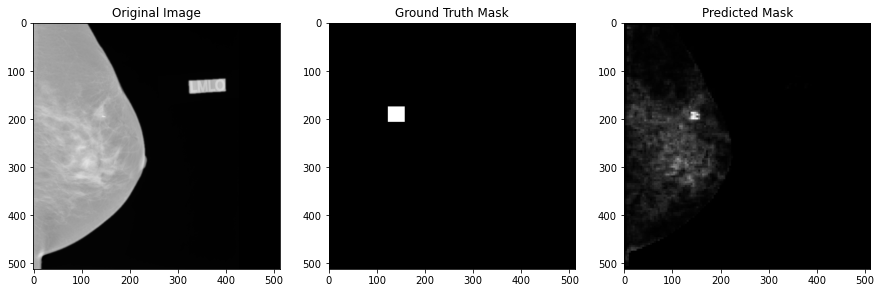

  0%|          | 0/1023 [00:00<?, ?it/s]

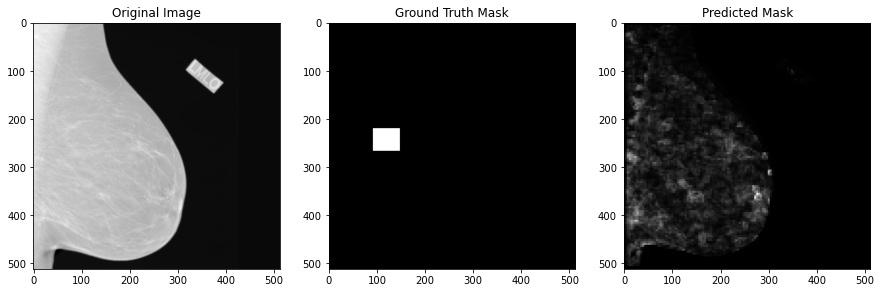

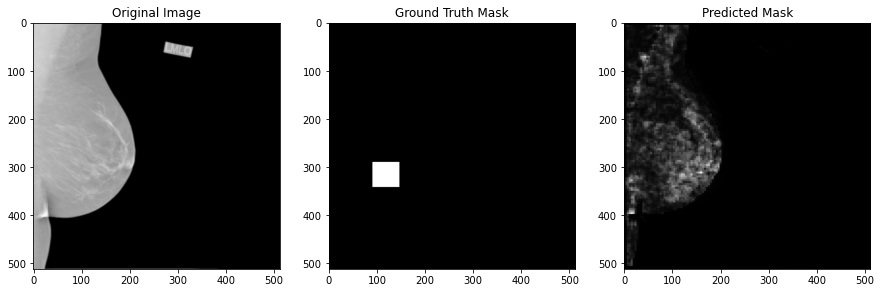

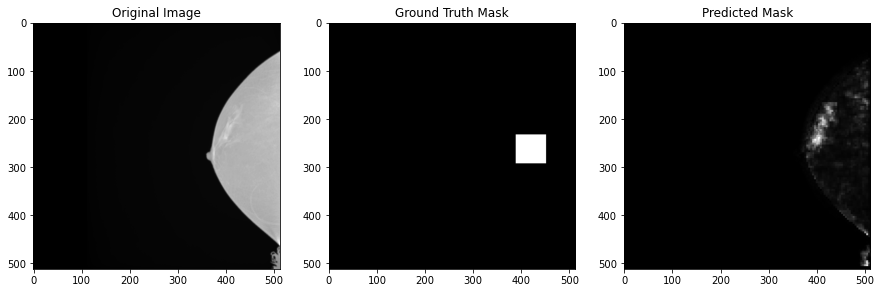

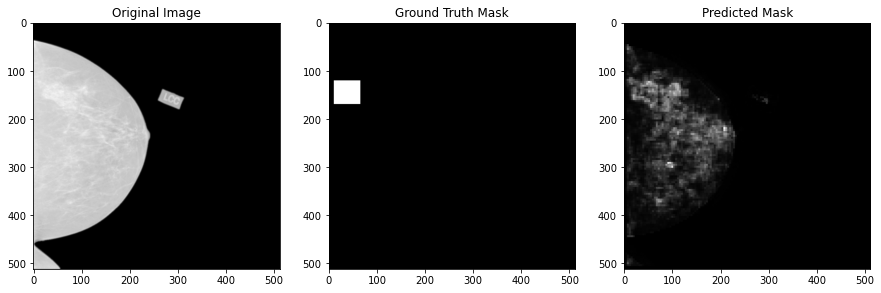

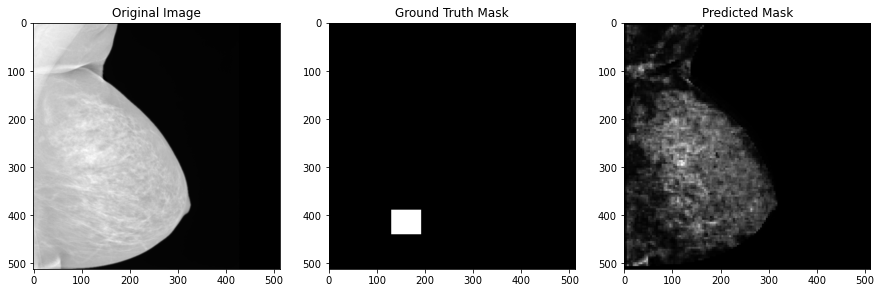

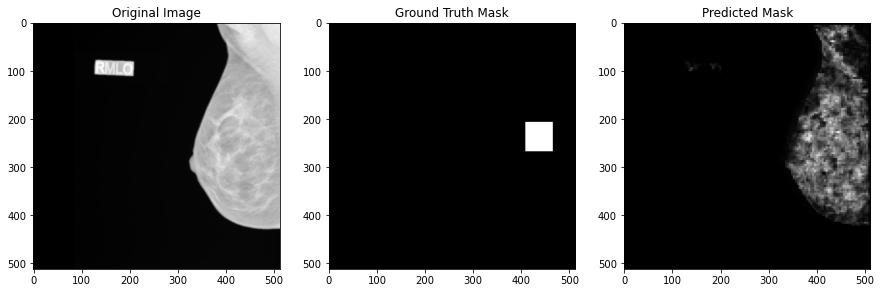

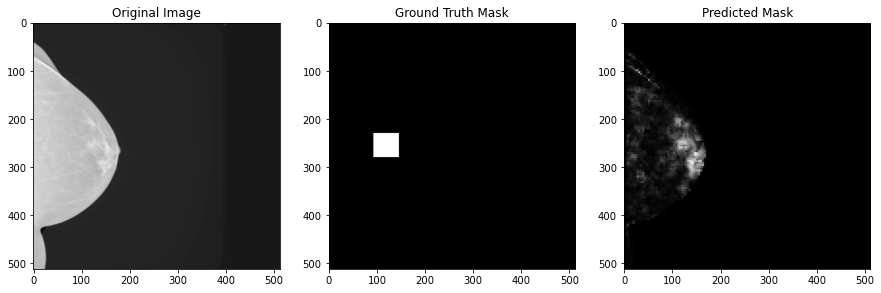

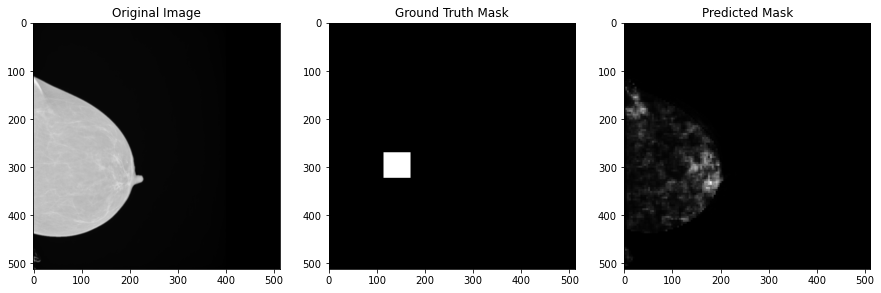

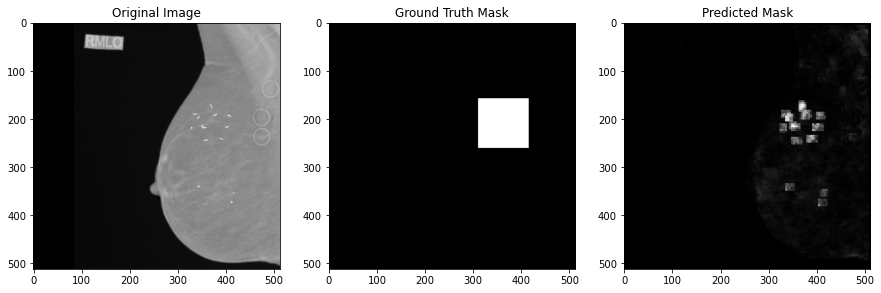

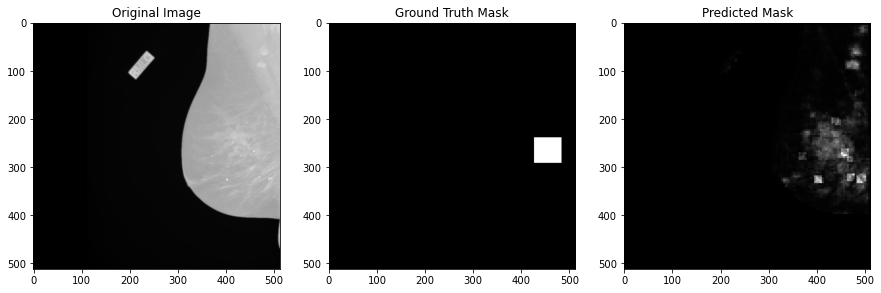

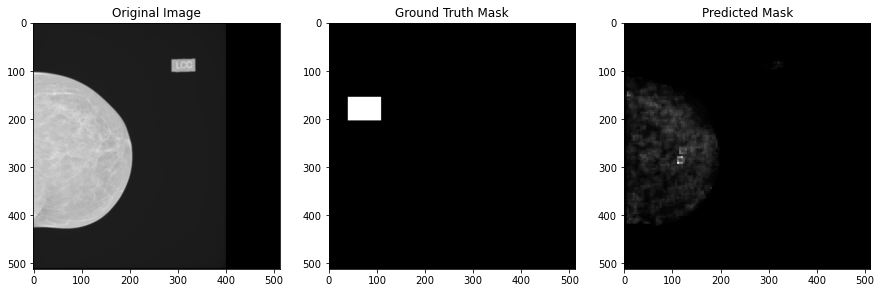

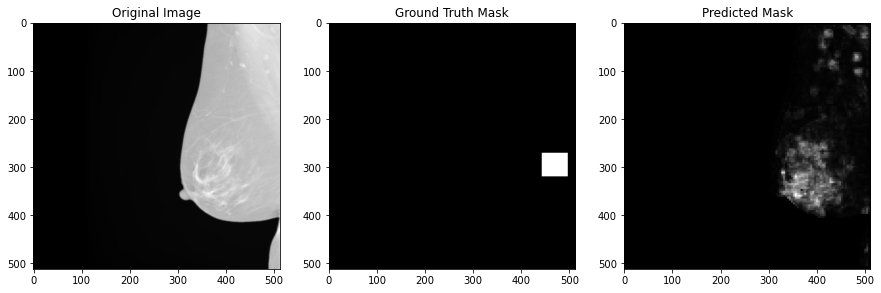

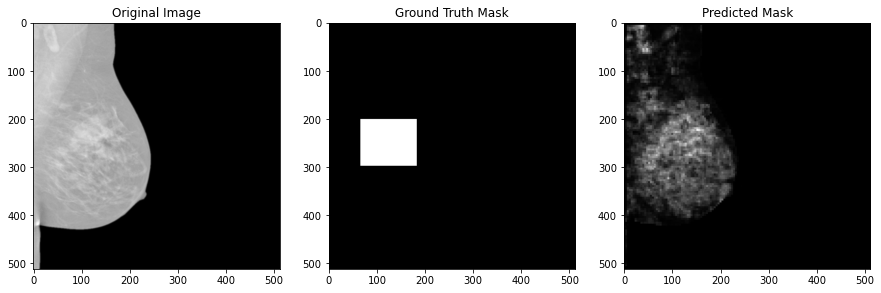

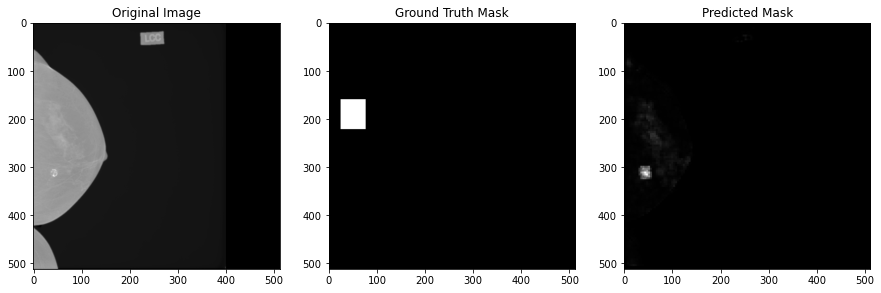

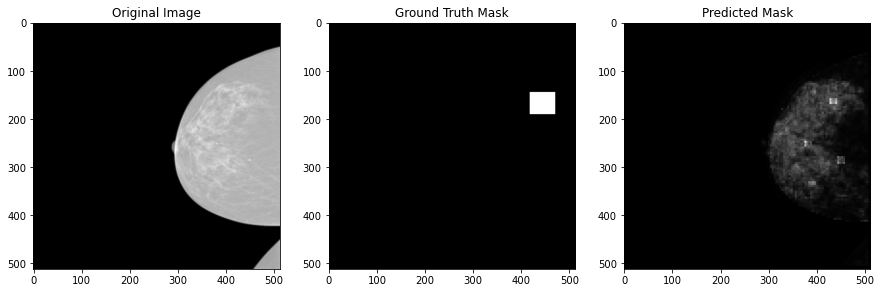

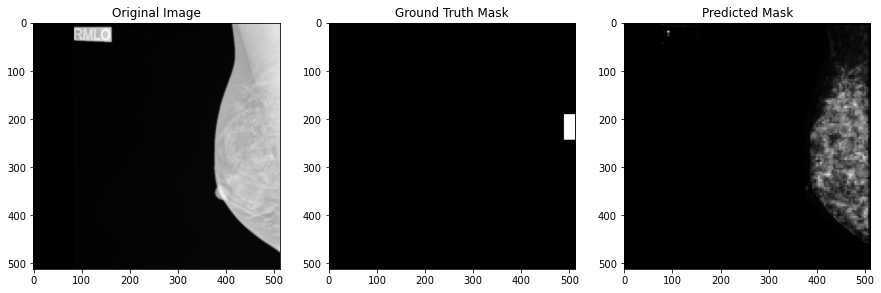

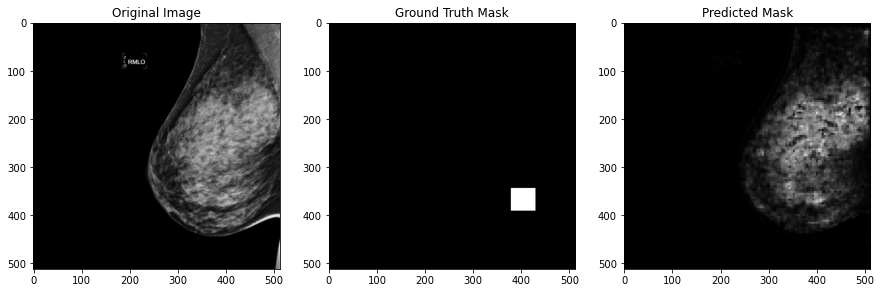

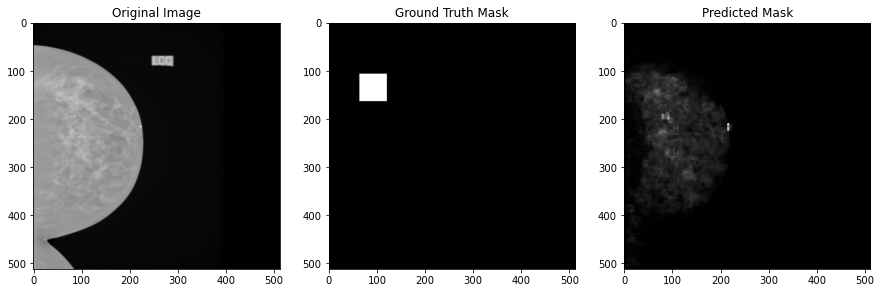

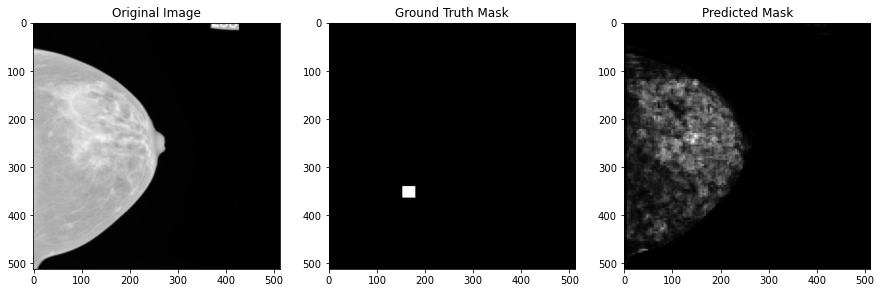

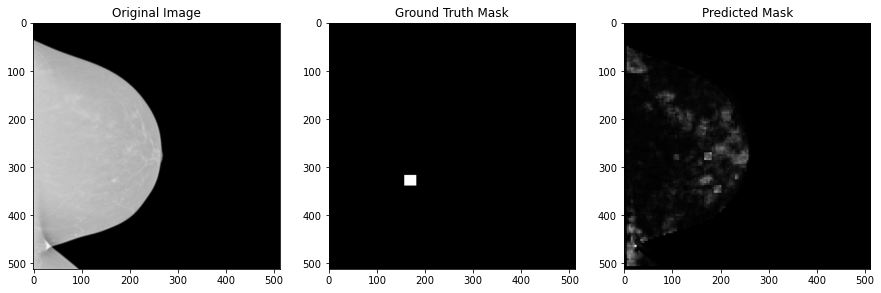

In [17]:
from matplotlib import pyplot as plt
import numpy as np

# Initialize progress bar and storage list
all_predictions = []

with tqdm(total=test_steps, dynamic_ncols=True) as pbar:
    for i in range(test_steps):
        batch_data, ground_truth_masks = next(test_generator)
        
        # Make predictions
        predicted_masks = model.predict(batch_data, verbose=0)
        
        # Append predictions to all_predictions list
        all_predictions.append(predicted_masks)
        
        # Update progress bar
        pbar.update(1)
        
        # For demonstration, let's visualize the first image in the batch
        if i % 50 == 0:  # Adjust this frequency as needed
            plt.figure(figsize=(15, 5))
            
            # Plot original image
            plt.subplot(1, 3, 1)
            plt.title('Original Image')
            plt.imshow(np.squeeze(batch_data[0]), cmap='gray')
            
            # Plot ground truth mask
            plt.subplot(1, 3, 2)
            plt.title('Ground Truth Mask')
            plt.imshow(np.squeeze(ground_truth_masks[0]), cmap='gray')
            
            # Plot predicted mask
            plt.subplot(1, 3, 3)
            plt.title('Predicted Mask')
            plt.imshow(np.squeeze(predicted_masks[0]), cmap='gray')
            
            plt.show()
